In [48]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from sklearn.utils import resample
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score


# df = pd.read_csv('./data/heart.csv')
# df = df.dropna(axis=1)
# X = df.drop('target', axis=1)
# y = df['target']

dataset = fetch_openml(name="credit-g")
df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                            columns=dataset['feature_names'] + ['target'])
print(df.shape)
df.head()

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


(1000, 21)


<IPython.core.display.Javascript object>


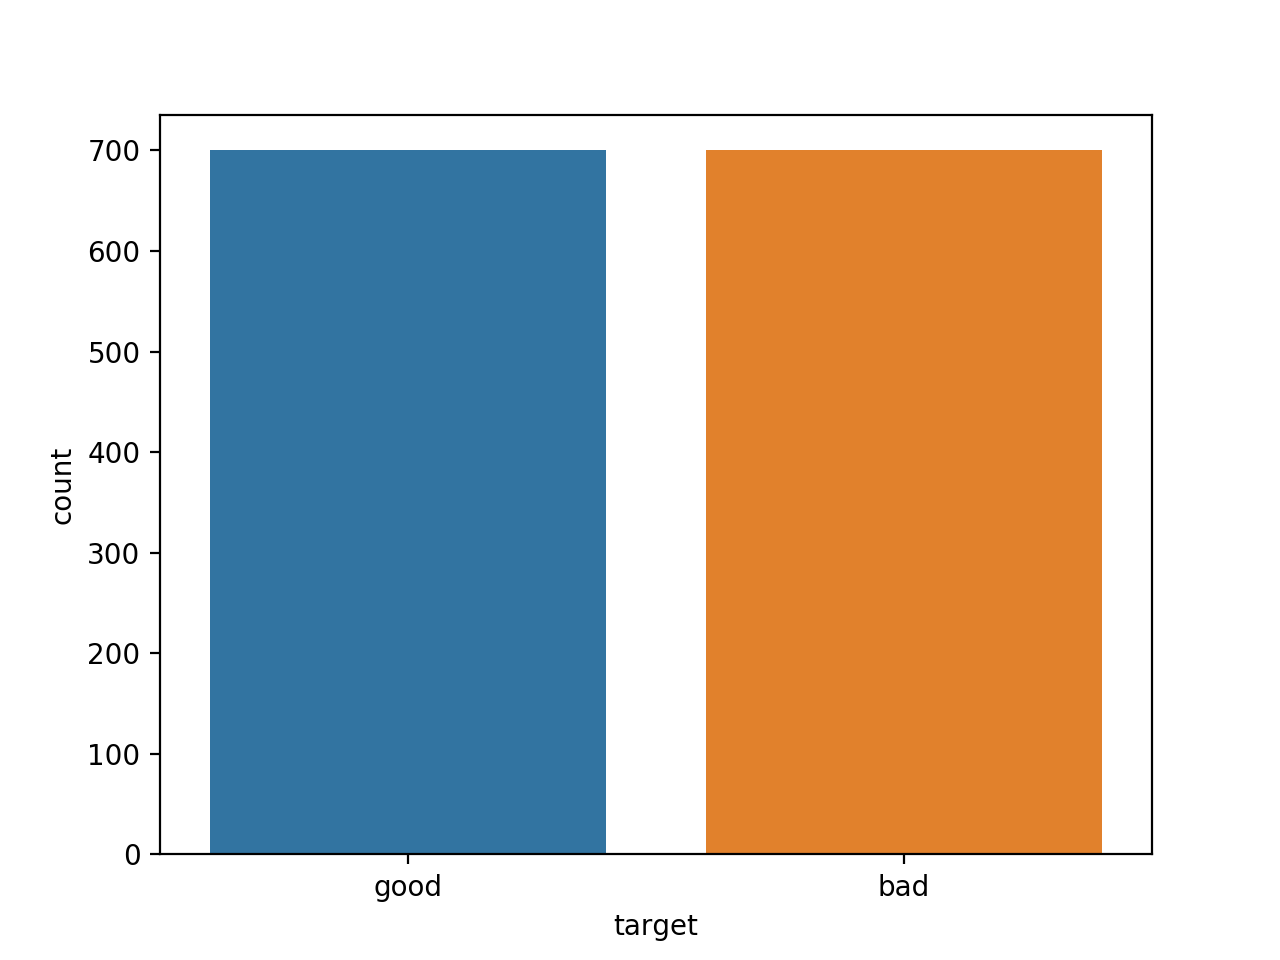

In [18]:
# df.target = pd.to_numeric(df.target, errors='coerce')
# df["target"] = df.target.map("{:02}".format)
sns.countplot(x="target", data=df)

In [19]:
df_majority = df[df.target=="good"]
df_minority = df[df.target=="bad"]
n_samples = df_majority.shape[0] - df_minority.shape[0]
df_up = resample(df_minority, replace=True, n_samples=n_samples, random_state=100)
df_up = pd.concat([df,df_up])
sns.countplot(x="target", data=df_up)

<IPython.core.display.Javascript object>


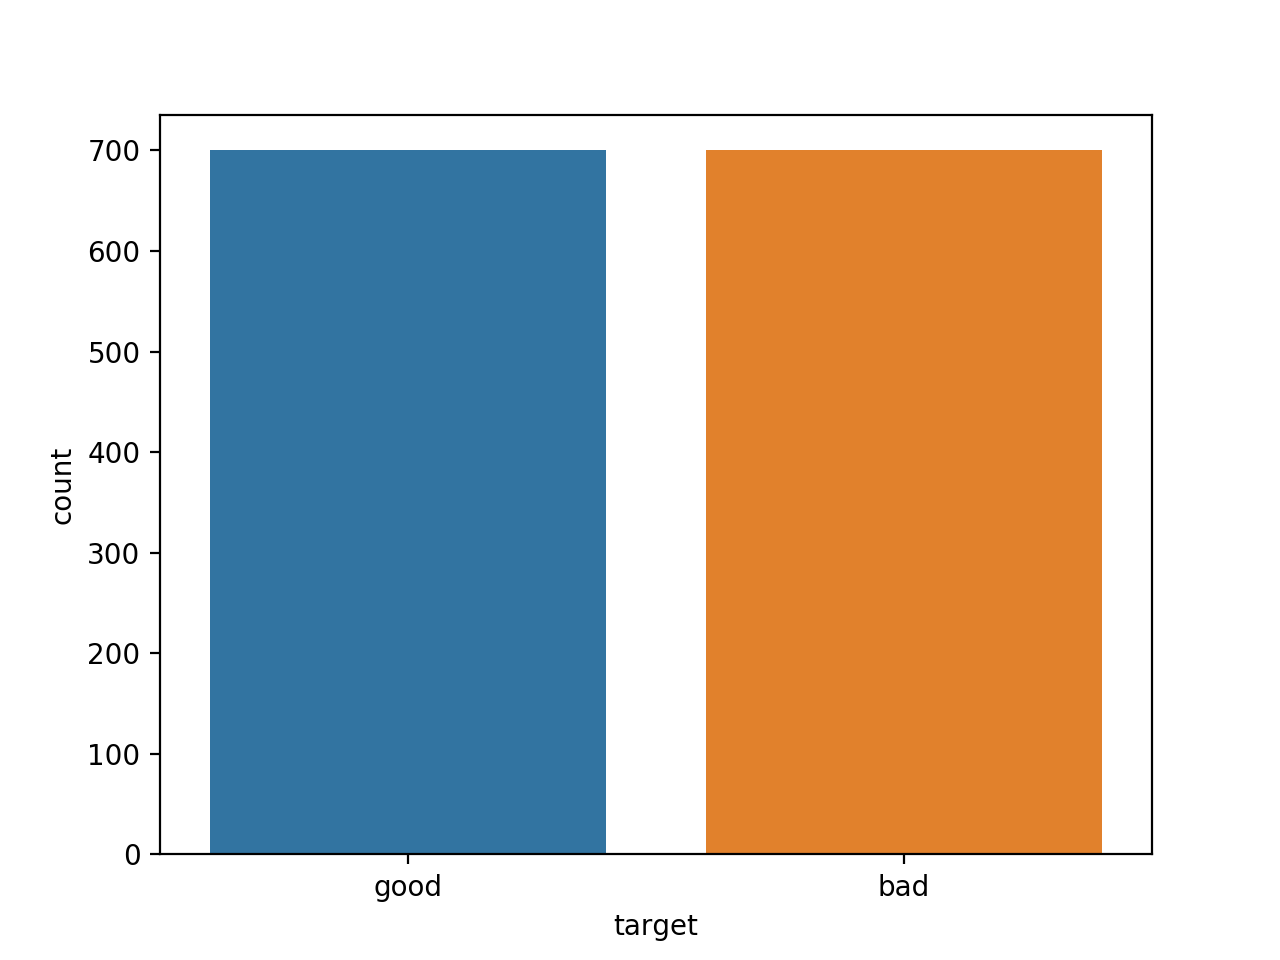

In [10]:
%matplotlib notebook
sns.countplot(x="target", data=df_up)

In [20]:
from sklearn.model_selection import train_test_split
X = df_up.drop('target', axis=1)
y = df_up['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)


def count_class(y):
    unique, counts = np.unique(y, return_counts=True)
    uqc = dict(zip(unique, counts))
    print(uqc)


count_class(y_train)


{'bad': 560, 'good': 560}


In [45]:
#Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_learning_curve(estimator, title, X, y, scoring="accuracy"):
    
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    n_jobs=None
    train_sizes=np.linspace(.1, 1.0, 20)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-Validation score")

    plt.legend(loc="best")
    return plt

def plot_model_complexity_curve(estimator, title, X, y, param_grid, scoring="accuracy"):
    param = list(param_grid.keys())[0]

    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    gs = GridSearchCV(estimator,
                  scoring=scoring,
                  cv=cv,
                  param_grid=param_grid)
    gs.fit(X, y)
    results = gs.cv_results_

    train_scores_mean = results[f"mean_train_score"]
    test_scores_mean = results[f"mean_test_score"]
    

    x_axis = results[f"param_{param}"].data
    new_axis = []
    for p in x_axis:
        if isinstance(p, tuple):
            j = '_'.join([str(x) for x in p])
            new_axis.append(j)
    if new_axis:
        x_axis = np.array(new_axis)
            
    plt.figure()
    plt.title(title)
    plt.xlabel(f"Model Complexity ({param})")
    plt.ylabel(scoring)
    plt.grid()
    plt.plot(x_axis, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(x_axis, test_scores_mean, 'o-', color="g",
             label="Cross-Validation score")
    plt.legend(loc="best")
    return plt  

def search_gridcv(estimator, X, y, param_grid, scoring="accuracy"):
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    gs = GridSearchCV(estimator,
                  scoring=scoring,
                  cv=cv,
                  param_grid=param_grid)
    gs.fit(X, y)
    results = gs.cv_results_
    print(gs.best_estimator_)
    print(gs.best_score_)
    print(gs.best_params_)
    
def boxplot_cv_scores(title, models, X, y, scoring=scoring):
    results = []
    names = []
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    for name, estimator in models:
        _results = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
        results.append(_results)
        names.append(name)
        print(f"{name}: {_results.mean()} ({_results.std()})")

    # boxplot for algorithm comparision
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    plt.ylabel("Cross-Validation Score")
    ax.set_ylim([0,1])
    ax.set_xticklabels(names)
    plt.show()
    
def accuracy_score_report(models, X_train, y_train, X_test, y_test, scoring=scoring):
    for name, estimator in models:
        clf = estimator.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["good", "bad"])
        print(f"{name}: {score}")


DecisionTree: 0.8142857142857143
MLP: 0.5392857142857143
Boosting: 0.8285714285714286
SVM: 0.9
KNN: 0.6214285714285714
DecisionTree: 0.8257142857142856 (0.02410648147240888)
MLP: 0.6010714285714286 (0.07205174586110079)
Boosting: 0.8221428571428572 (0.021887933494349362)
SVM: 0.9 (0.022131333406899538)
KNN: 0.625 (0.015730511103960874)


<IPython.core.display.Javascript object>


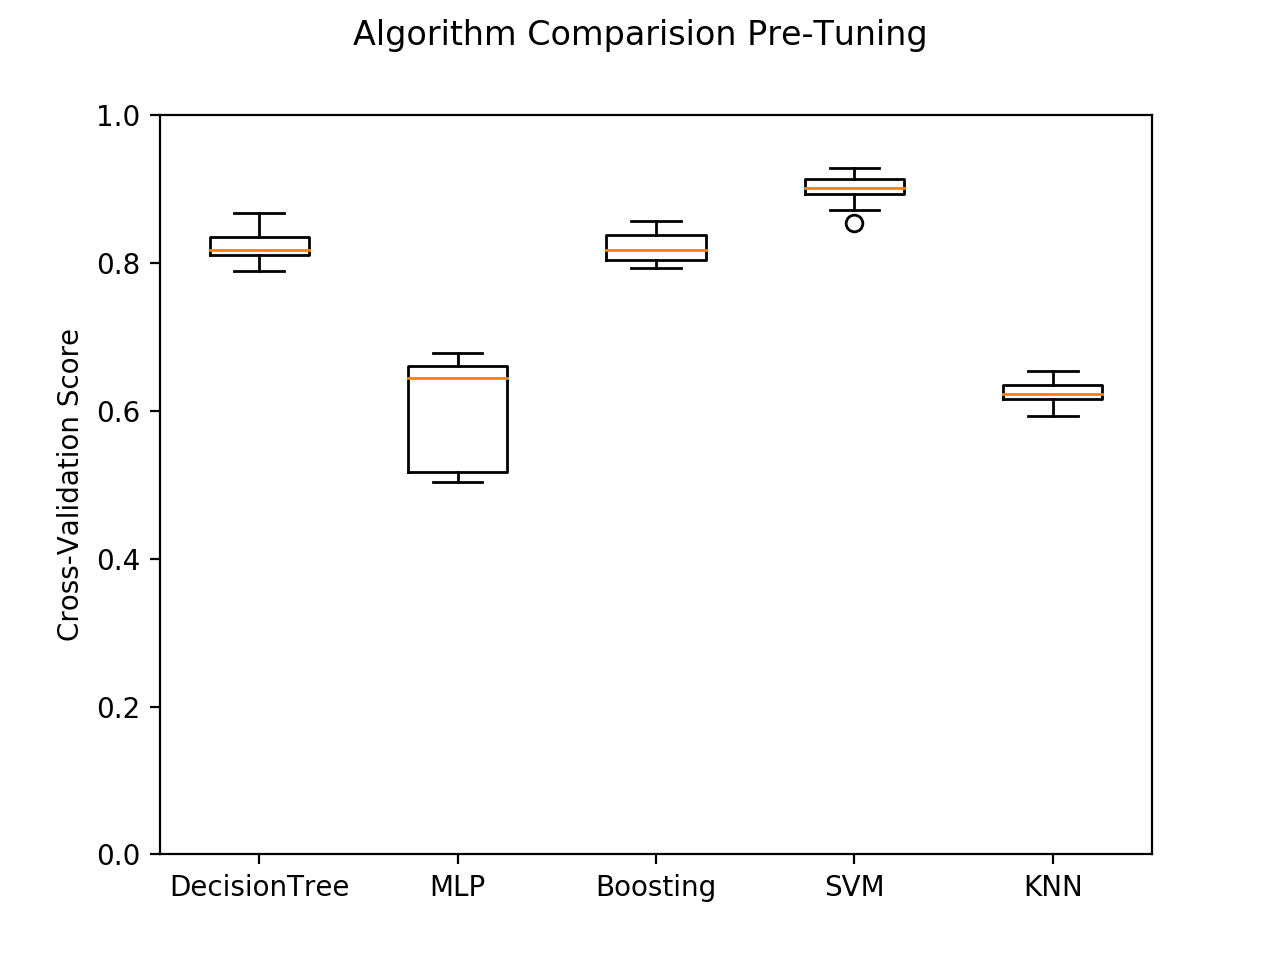

In [46]:
scoring='accuracy'
models = [
    ('DecisionTree', DecisionTreeClassifier()),
    ("MLP", MLPClassifier()),
    ("Boosting", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("SVM", SVC()),
    ("KNN", KNeighborsClassifier())
]

accuracy_score_report(models, X_train, y_train, X_test, y_test, scoring=scoring)

boxplot_cv_scores("Algorithm Comparision Pre-Tuning",models, X, y, scoring=scoring)

DecisionTree: 0.7928571428571428
MLP: 0.7035714285714286
Boosting: 0.8357142857142857
SVM: 0.9
KNN: 0.7857142857142857
DecisionTree: 0.8028571428571428 (0.025294187442322535)
MLP: 0.7189285714285714 (0.028259457510283355)
Boosting: 0.8139285714285714 (0.02048207279848524)
SVM: 0.9 (0.022131333406899538)
KNN: 0.79 (0.023625479155058894)


<IPython.core.display.Javascript object>


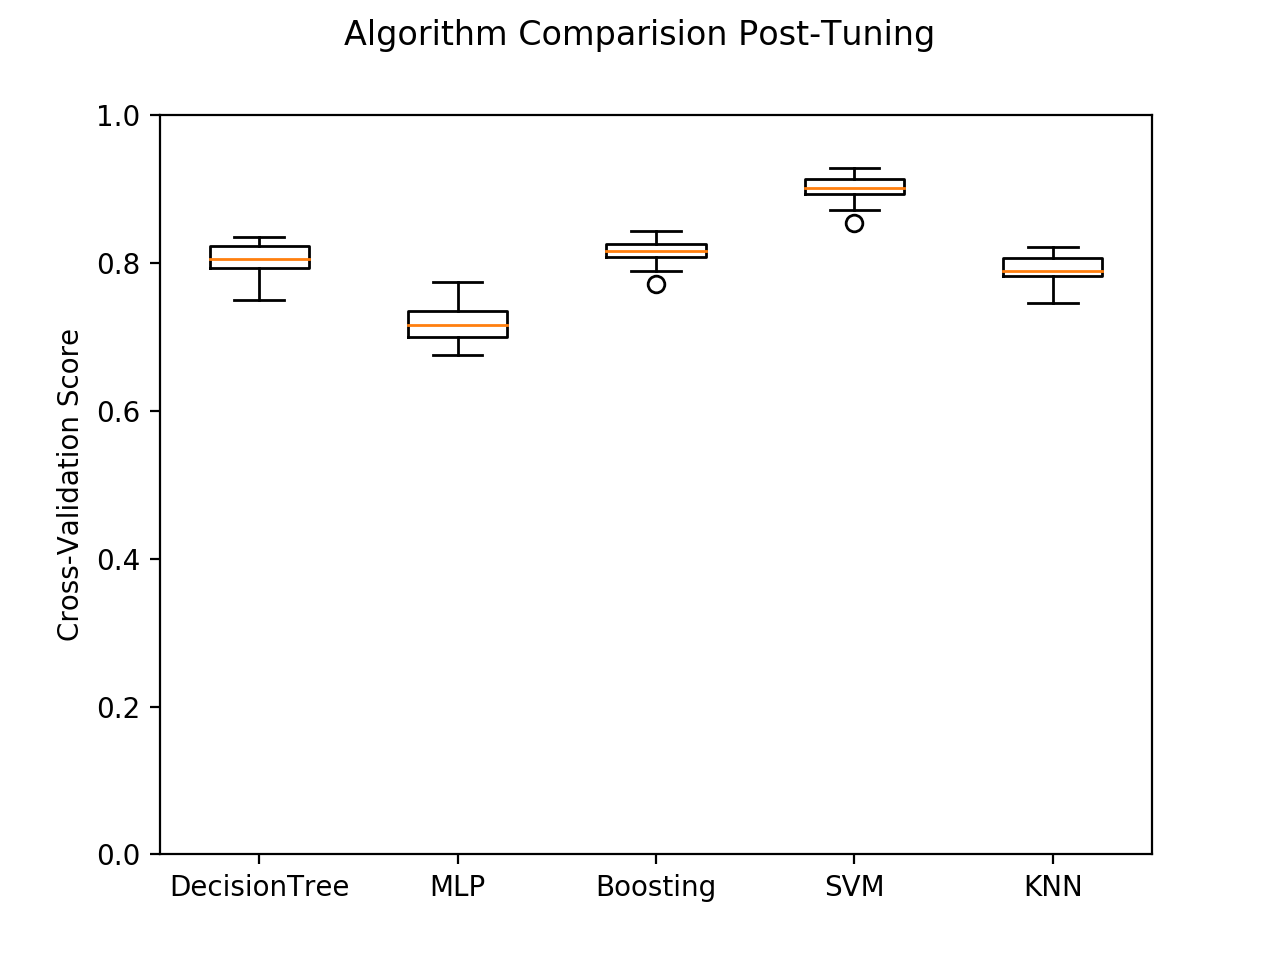

In [47]:
models = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=30, min_samples_leaf=2)),
    ("MLP", MLPClassifier(activation="logistic", hidden_layer_sizes=(70,), solver="adam")),
    ("Boosting", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=9), n_estimators=20, learning_rate=1)),
    ("SVM", SVC()),
    ("KNN", KNeighborsClassifier(n_neighbors=1))
]

accuracy_score_report(models, X_train, y_train, X_test, y_test, scoring=scoring)

boxplot_cv_scores("Algorithm Comparision Post-Tuning", models, X, y, scoring=scoring)